# U4 - Abdullah Barhoum (5041774) - Katharina Müller (5284090)

# Assignment 4: Hough Transform

In [3]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np
from skimage.draw import line
import math

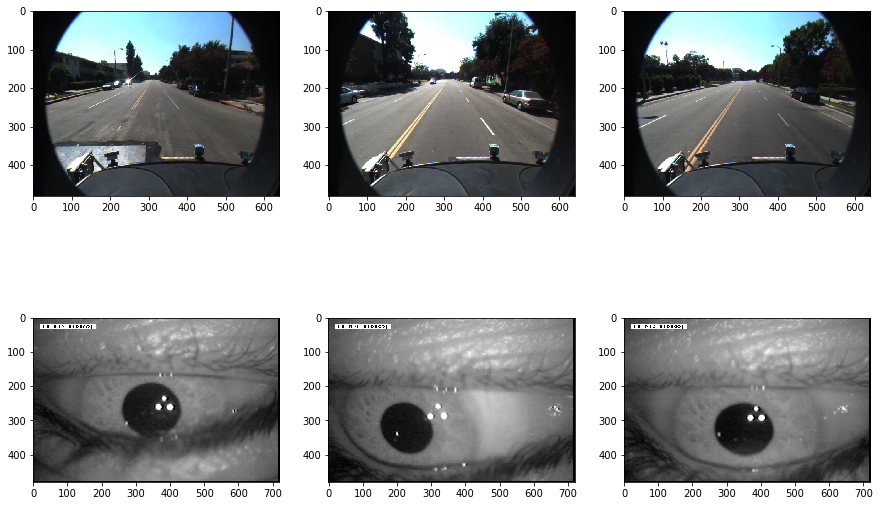

In [4]:
lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00050.png')
lane3 = io.imread('images/lane_detection/f00090.png')

eye1 = io.imread('images/eye_tracking/0000.jpeg')
eye2 = io.imread('images/eye_tracking/0050.jpeg')
eye3 = io.imread('images/eye_tracking/0090.jpeg')

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 3, 1)
ax12 = plt.subplot(2, 3, 2)
ax13 = plt.subplot(2, 3, 3)
ax21 = plt.subplot(2, 3, 4)
ax22 = plt.subplot(2, 3, 5)
ax23 = plt.subplot(2, 3, 6)



ax11.imshow(lane1)
ax12.imshow(lane2)
ax13.imshow(lane3)

ax21.imshow(eye1)
ax22.imshow(eye2)
ax23.imshow(eye3)


## Ex. 4.1 Detect lanes and eyes

* there are two datasets available: "images/eye_tracking" and "images/lane_detection" - decide for one of them
* implement the classical Hough Transform for lines (for lane detection) **OR** circles (eye tracking) as shown in the lecture
* use a Canny edge detector to produce edge images for the sequence of images

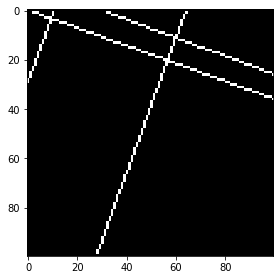

In [5]:
# dieser Code wurde als Musterlösung von Sebastian Oltmanns zur Verfügung gestellt und von Tim renoviert

def draw_line_hessian_normal(image, a, r):
    
    (dimy,dimx) = image.shape

    #r = x*cosa + y*sina

    # compute start and end point of line 
    x0 = 0
    y0 = round((r - x0*math.cos(math.radians(a)))/math.sin(math.radians(a)))
    x1 = dimx
    y1 = round((r - x1*math.cos(math.radians(a)))/math.sin(math.radians(a)))

    liney,linex = line(y0,x0,y1,x1)
    
    ret = np.copy(image)
    for yy in range(0,liney.size-1):
        if (liney[yy] > 0) and (liney[yy] < dimy-1):
            ret[liney[yy],linex[yy]] = 1
    return ret

image = np.zeros((100,100))
image = draw_line_hessian_normal(image, 20, 60)
image = draw_line_hessian_normal(image, 20, 10)
image = draw_line_hessian_normal(image, 110, 0)
image = draw_line_hessian_normal(image, -70, 10)
io.imshow(image)

## OPTION 1: line detection for lane detection 

* use your implementation of the Hough Transform to find the 10 strongest lines in the image
* display your result set (draw those lines on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw lines again! (**BONUS**)

## OPTION 2: circle detection for eye detection
* use your implementation of the Hough Transform to find the 10 strongest circles in the image
* display your result set (draw those circles on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw circles again! (**BONUS**)

# Ex. 3.2 Generalized Hough Transform

* implement the Generalized Hough Transform as described in the lecture for localizing a given template
* find the given template (see below) and mark its location in the image "animals.png" (**RESULT**)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
from skimage.filters import sobel_h, sobel_v, gaussian
from skimage.feature import canny
from skimage.color import rgb2gray
from skimage.draw import circle
import numpy as np

full_circle = 2 * np.pi


def get_theta(img, gauss_sigma):
    blurred = gaussian(img, gauss_sigma)
    g_x, g_y = sobel_v(blurred), sobel_h(blurred)
    return (np.arctan2(g_y, g_x) + full_circle) % full_circle


def edges(img, gauss_sigma):
    return canny(img, gauss_sigma).nonzero()


def create_R_table(img, num_steps, gauss_sigma=1):
    theta = get_theta(img, gauss_sigma)

    edge_y, edge_x = edges(img, gauss_sigma)
    cy, cx = edge_y.mean(), edge_x.mean()

    step_size = full_circle / num_steps
    table = {index: [] for index in range(num_steps)}
    for y, x in zip(edge_y, edge_x):
        v = (cy - y, cx - x)
        bin_index = int(theta[y, x] // step_size)
        table[bin_index].append(v)
    return table


def GHT(img, table, gauss_sigma=1):
    accumulator = np.zeros_like(img)
    H, W = accumulator.shape

    theta = get_theta(img, gauss_sigma)
    edge_y, edge_x = edges(img, gauss_sigma)
    num_steps = len(table)
    step_size = full_circle / num_steps
    for y, x in zip(edge_y, edge_x):
        bin_index = int(theta[y, x] // step_size)
        for (offset_y, offset_x) in table[bin_index]:
            cy = int(y + offset_y)
            cx = int(x + offset_x)
            if H > cy >= 0 and W > cx >= 0:
                accumulator[cy, cx] += 1

    return accumulator

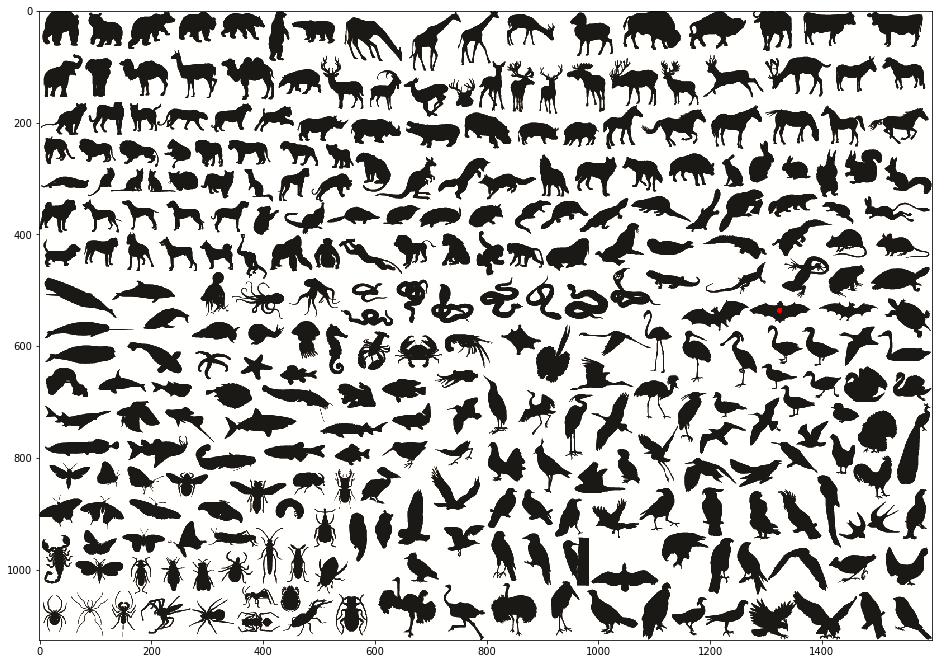

In [2]:
animals = io.imread('images/animals.png')
bat = animals[519:561, 1271:1381]

angle_steps = 180
table = create_R_table(rgb2gray(bat), angle_steps)
acc = GHT(rgb2gray(animals), table)

cy, cx = np.unravel_index(np.argmax(acc), acc.shape)
animals[circle(cy, cx, 5)] = np.array([255, 0, 0])

plt.figure(figsize=(16, 16))
plt.imshow(animals)
plt.show()

## BONUS 
* now implement an extended version of the GHT that find rotated and scaled variants of the template. 
* find Italy (see "italy.jpg") and the map of Europe ("europe_map_political.gif")
* note that you can binarize your italy template by using a simple color lookup
* draw the location of italy on the map and print its scale and orientation (**BONUS**)